# Regridding climate data with xESMF

A common element of climate data workflows is regridding, or reprojection, of model data unto more standard grids, or simply unto another dataset's grid. The powerful [ESMF](https://earthsystemmodeling.org/docs/release/ESMF_8_0_1/ESMF_usrdoc/) program, written in FORTRAN, has long been a reference in the matter. The [xESMF](https://pangeo-xesmf.readthedocs.io/en/latest/) python package provides an easy to use high-level API for using ESMF's methods. This notebook shows some examples of common regridding operations.

Regridding with `xESMF` is usually a two-step process:

 1. Create a `Regridder` objects from two datasets, defining the input and the output grids. This computation a weights mask which can, if needed, be saved to a netCDCF file.
 2. Regrid a DataArray or Dataset by calling the `Regridder` with it. As the weights have already been computed, it reuses them for all time slices, which allows much better performance than, for example, interpolation using `scipy.interpolation.interpn`.

In [29]:
# NBVAL_IGNORE_OUTPUT

import copy
import json
import warnings
from tempfile import NamedTemporaryFile

warnings.filterwarnings("ignore", category=DeprecationWarning)

import cf_xarray as cfxr
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
import xarray as xr
import xesmf as xe
from clisops.core.subset import subset_bbox
from owslib.wfs import WebFeatureService

#  A colormap with grey where the data is missing
cmap = copy.copy(plt.cm.get_cmap("viridis"))
cmap.set_bad("lightgray")

## Simple example : Bilinear regridding from model to obs

Our input in this example is a year of monthly sea ice concentration data from a CanESM5 run for CMIP6. It lies on an irregular grid defined by `latitude` and `longitude` coordinates. We'll interpolate the sea ice concentration to a regular observational grid from Natural Resources Canada. 

### The input data

In [30]:
# NBVAL_IGNORE_OUTPUT

# The input test data is hosted on the Ouranos THREDDS
url = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/testdata/xclim/cmip6/sic_SImon_CCCma-CanESM5_ssp245_r13i1p2f1_2020.nc"
ds_in = xr.open_dataset(url)
ds_in

<xarray.Dataset> Size: 14MB
Dimensions:             (time: 12, bnds: 2, j: 291, i: 360, vertices: 4)
Coordinates:
  * time                (time) object 96B 2020-01-16 12:00:00 ... 2020-12-16 ...
  * j                   (j) int32 1kB 0 1 2 3 4 5 6 ... 285 286 287 288 289 290
  * i                   (i) int32 1kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
    type                |S64 64B ...
    latitude            (j, i) float64 838kB ...
    longitude           (j, i) float64 838kB ...
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object 192B ...
    vertices_latitude   (j, i, vertices) float64 3MB ...
    vertices_longitude  (j, i, vertices) float64 3MB ...
    siconc              (time, j, i) float32 5MB ...
    areacello           (j, i) float32 419kB ...
Attributes: (12/56)
    CCCma_model_hash:                fc4bb7db954c862d023b546e19aec6c588bc0552
    CCCma_parent_runid:              p2-his13
    CCCma_pycmor_hash:               26c970628162d607fffd14254956ebc6dd3b6f49
    CCCma_runid:                     p2-s4513
    Conventions:                     CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:       2015:01:01:00
    ...                              ...
    license:                         CMIP6 model data produced by The Governm...
    cmor_version:                    3.5.0
    tracking_id:                     hdl:21.14100/9e4f804b-c161-44fa-acd1-c2e...
    DODS.strlen:                     64
    DODS.dimName:                    maxStrlen64
    DODS_EXTRA.Unlimited_Dimension:  time

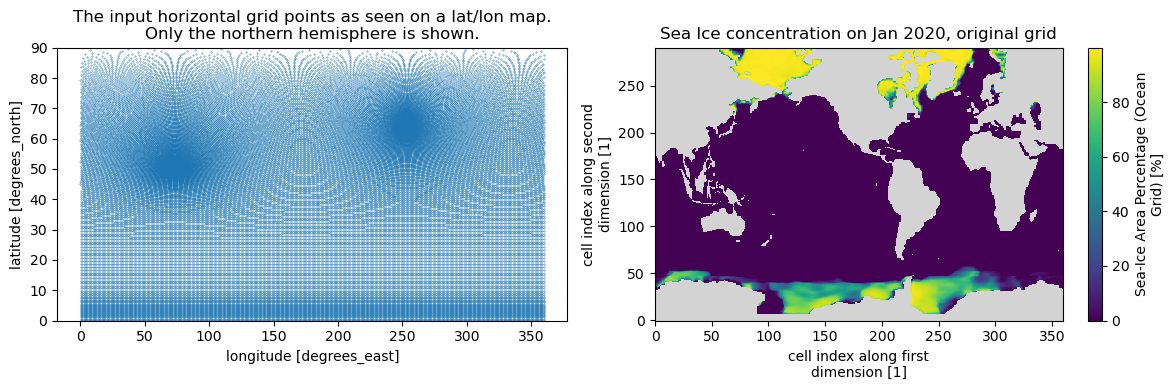

In [31]:
# Let's look at the grid shape itself and the data for one time step
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

axs[0].scatter(x=ds_in.longitude.values, y=ds_in.latitude.values, s=0.1)
axs[0].set_title(
    "The input horizontal grid points as seen on a lat/lon map.\nOnly the northern hemisphere is shown."
)
axs[0].set_ylim(0, 90)
axs[0].set_ylabel(f"latitude [{ds_in.latitude.units}]")
axs[0].set_xlabel(f"longitude [{ds_in.longitude.units}]")
ds_in.siconc.isel(time=0).plot(ax=axs[1], cmap=cmap)
axs[1].set_title("Sea Ice concentration on Jan 2020, original grid")
fig.tight_layout()

### The output grid

The NRCAN observations' dataset uses a simple rectangular lat/lon grid over Canada at about 10km resolution. To reduce computation time for this example, we'll first crop the grid to include only Hudson Bay and the Labrador Sea.

In [32]:
# NBVAL_IGNORE_OUTPUT

url_obs = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/gridded_obs/nrcan_v2.ncml"

# For this example, we're not interested in the observation data, only its underlying grid, so we'll select a single time step.
ds_obs = xr.open_dataset(url_obs).sel(time="1993-05-20").drop("time")

# Subset over the Hudson Bay and the Labrador Sea for the example
bbox = dict(lon_bnds=[-99.5, -41.92], lat_bnds=[50.35, 67.61])
ds_tgt = subset_bbox(ds_obs, **bbox)
ds_tgt

<xarray.Dataset> Size: 1MB
Dimensions:  (lat: 207, lon: 570)
Coordinates:
  * lat      (lat) float32 828B 67.54 67.46 67.38 67.29 ... 50.54 50.46 50.38
  * lon      (lon) float32 2kB -99.46 -99.38 -99.29 ... -52.21 -52.13 -52.04
Data variables:
    tasmin   (lat, lon) float32 472kB ...
    tasmax   (lat, lon) float32 472kB ...
    pr       (lat, lon) float32 472kB ...
Attributes: (12/15)
    Conventions:          CF-1.5
    title:                NRCAN ANUSPLIN daily gridded dataset : version 2
    history:              Fri Jan 25 14:11:15 2019 : Convert from original fo...
    institute_id:         NRCAN
    frequency:            day
    abstract:             Gridded daily observational dataset produced by Nat...
    ...                   ...
    dataset_id:           NRCAN_anusplin_daily_v2
    version:              2.0
    license_type:         permissive
    license:              https://open.canada.ca/en/open-government-licence-c...
    attribution:          The authors provide this data under the Environment...
    citation:             Natural Resources Canada ANUSPLIN interpolated hist...

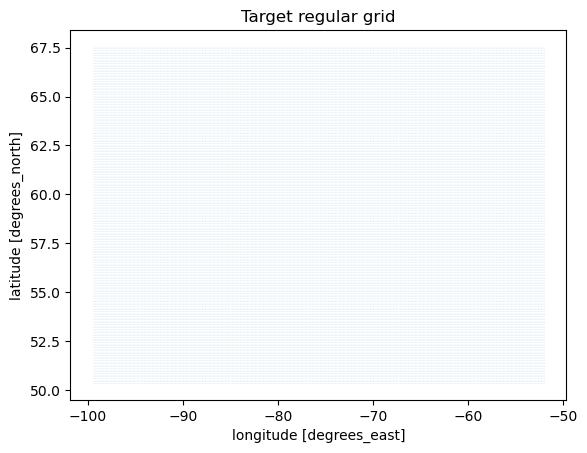

In [33]:
# NBVAL_IGNORE_OUTPUT

ds_tgt.cf.plot.scatter(x="longitude", y="latitude", s=0.1)
plt.title("Target regular grid");

xESMF relies on the useful [cf_xarray](https://cf-xarray.readthedocs.io/en/latest/) package to infer which variables are the latitude and longitude points. It will automatically know to use `longitude` and `latitude` on the datasets because their attributes are correctly set, as `ds.cf.describe()`  shows:

In [34]:
# NBVAL_IGNORE_OUTPUT

ds_in.cf.describe()

Coordinates:
             CF Axes: * X: ['i']
                      * Y: ['j']
                      * T: ['time']
                        Z: n/a

      CF Coordinates:   longitude: ['longitude']
                        latitude: ['latitude']
                      * time: ['time']
                        vertical: n/a

       Cell Measures:   area, volume: n/a

      Standard Names:   area_type: ['type']
                        latitude: ['latitude']
                        longitude: ['longitude']
                      * time: ['time']

              Bounds:   n/a

       Grid Mappings:   n/a

Data Variables:
       Cell Measures:   area: ['areacello']
                        volume: n/a

      Standard Names:   cell_area: ['areacello']
                        sea_ice_area_fraction: ['siconc']

              Bounds:   T: ['time_bnds']
                        latitude: ['vertices_latitude']
                        longitude: ['vertices_longitude']
                        time: ['time_b

If those attributes were **not** set, we would need to rename the coordinates to `lon` and `lat`, xESMF's default's coordinate names.

### Regridding input data unto the output grid

First we create the regridding object, using the "bilinear" method, and then simply call it with the array that we want regridded (here `siconc`).

In [35]:
reg_bil = xe.Regridder(ds_in, ds_tgt, "bilinear")
reg_bil  # Show information about the regridding

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_291x360_207x570.nc 
Reuse pre-computed weights? False 
Input grid shape:           (291, 360) 
Output grid shape:          (207, 570) 
Periodic in longitude?      False

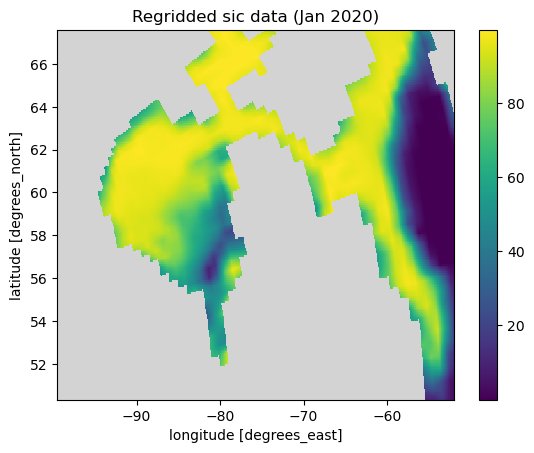

In [36]:
# NBVAL_IGNORE_OUTPUT

# xesmf/frontend.py:476: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
warnings.filterwarnings("ignore", category=FutureWarning)

# Apply the regridding weights to the input sea ice concentration data
sic_bil = reg_bil(ds_in.siconc)

# Plot the results
sic_bil.isel(time=0).plot(cmap=cmap)
plt.title("Regridded sic data (Jan 2020)");

The output now has the same grid as the target! The regridding operation was broadcasted along the non spatial dimensions (here `time`), so that all time steps were regridded using the same pre-computed weights.

## Second example : Conservative regridding and reusing weights

xESMF provides the following regridding methods : "bilinear", "conservative", "conservative_normed", "nearest_s2d", "nearest_d2s" and "patch" (see [method descriptions](https://earthsystemmodeling.org/regrid/#regridding-methods)). Conservative methods preserve areal averages, and for these methods we need to provide the coordinates of the grid cells' corners rather than the coordinates at the cells center.

### Untangling corners definitions

Before we go further, it's worth highlighting differences between xESMF's description of corner coordinates and how the same information is stored in CF-compliant files. 

For an `N x M` lon/lat grid,  xESMF expects an array with one element more than the coordinates. For example, on a regular grid, the corner of point at `lon[0]` are given by `lon_b[0]` and `lon_b[1]`. However, in a typical CF-compliant file, *grid corner* information is in an array of shape (N, 2) typically called `lon_bounds` and `lat_bounds`. Thus, the western and eastern corners of point at `lon[0]` are given by `lon_corners[0, 0]` and `lon_corners[0, 1]`. 

The `cf_xarray` package differentiates the two concepts by naming the CF-compliant one "bounds" and the xESMF one "vertices". However, CF conventions sometime uses vertices and bound interchangeably, and in our model dataset, the `vertices_longitude` variable stores corners according to the "bounds" definition...  We will nevetheless stick with `cf_xarray`'s nomenclature in the following.

The table below summarizes the difference between the two versions:

|                        | bounds    | vertices   |
|------------------------|-------------|--------------|
| CF-compliant           | Yes         | No           |
| Shape (regular grid)   | (N, 2)      | (N+1,)       |
| Shape (irregular grid) | (Nx, Ny, 4) | (Nx+1, Ny+1) |


### Computing the corners

The corners of regular grids (1D lat/lon) are infered automatically if not given. This will be the case for our `ds_tgt` dataset.

For irregular grids, `xESMF` will check for variables `lon_b` and `lat_b`, or try automatic detection with the help of `cf_xarray`. If they are found, it uses `cf_xarray`'s method to convert from the CF-compliant "bounds" to the required "vertices" syntax. However, a small bug in xESMF 0.5.2 prevents use from using this feature with our model dataset. We will convert the corner variables ourselves from the CF-compliant format we have to the format xESMF expects.

In [37]:
# Get the bounds variable and convert them to "vertices" format
# Order=none, means that we do not know if the bounds are listed clockwise or counterclockwise, so we ask cf_xarray to try both.
lat_corners = cfxr.bounds_to_vertices(ds_in.vertices_latitude, "vertices", order=None)
lon_corners = cfxr.bounds_to_vertices(ds_in.vertices_longitude, "vertices", order=None)
ds_in_crns = ds_in.assign(lon_b=lon_corners, lat_b=lat_corners)

### Regridding

The regridding process is as simple as above now that `ds_in_crns` contains the corner coordinates (`lon_b`, `lat_b`). Here we also pass a filename, so that the weights are saved to disk and can be reused (see below).

In [38]:
%%time

conservative_regridder = NamedTemporaryFile(delete=False, suffix=".nc")

reg_cons = xe.Regridder(
    ds_in_crns, ds_tgt, "conservative", filename=conservative_regridder.name
)
print(reg_cons)

# Regrid as before
sic_cons = reg_cons(ds_in_crns.siconc)

xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            /tmp/tmpwodwouah.nc 
Reuse pre-computed weights? False 
Input grid shape:           (291, 360) 
Output grid shape:          (207, 570) 
Periodic in longitude?      False
CPU times: user 3.56 s, sys: 14.1 ms, total: 3.57 s
Wall time: 3.58 s


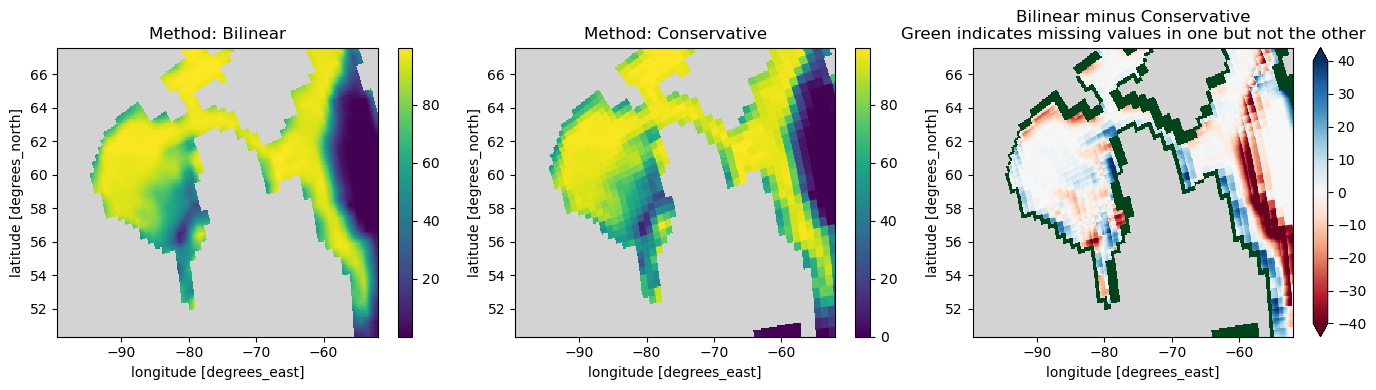

In [39]:
# Now let's look at the results
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

sic_bil.isel(time=0).plot(ax=axs[0], cmap=cmap)
axs[0].set_title("Method: Bilinear")

sic_cons.isel(time=0).plot(ax=axs[1], cmap=cmap)
axs[1].set_title("Method: Conservative")

# A divergent colormap with gray on missing values
cmap_div = copy.copy(plt.cm.get_cmap("RdBu"))
cmap_div.set_bad("lightgray")
(sic_bil - sic_cons).isel(time=0).plot(ax=axs[2], cmap=cmap_div, vmin=-40, vmax=40)
diff_NaNs = (sic_bil.isnull() ^ sic_cons.isnull()).isel(time=0)
diff_NaNs.where(diff_NaNs).plot(
    cmap=plt.cm.Greens, ax=axs[2], vmin=0, add_colorbar=False
)
axs[2].set_title(
    "Bilinear minus Conservative\nGreen indicates missing values in one but not the other"
)
fig.tight_layout()

As we can see, "bilinear" regridding results in a smooth output field, while "conservative" results preserves the original data's coarser resolution. In the last panel, the green cells show that the two methods have different missing values results. In our case of increasing resolution, there will often be more missing values when using "bilinear". The next example explains how xESMF can explictely manage missing values. But before, we look at the reusability of the weights generated by xESMF.

### Reusing weights

The weights of the previous regridding have been written to disk. We can simply reuse them by specifying that filename and passing `reuse_weights=True`. You'll notice how faster the process is, as we don't compute the weights again.

In [40]:
%%time

conservative_regridder_weights = NamedTemporaryFile(delete=False, suffix=".nc")

reg_bis = xe.Regridder(
    ds_in_crns,
    ds_tgt,
    "conservative",
    reuse_weights=True,
    filename=conservative_regridder_weights.name,
)
print(reg_bis)

# Regrid as before
sic_bis = reg_bis(ds_in_crns.siconc)

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy', 'pydap', 'rasterio', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

## Third example : Regridding and masks

By defaut, xESMF doesn't handle missing values in a special way, so when they are present in the input data they often bleed into the regridded field, especially when decreasing resolution. This example demonstrates this bleeding effect and how it can be mitigated using masks.

We will use a global model dataset and try to regrid the NRCAN observation unto the global grid, thus decreasing the resolution.


### Target grid and mask

The target grid will be the CanESM2 model grid, but with the ocean masked. In the following, we fetch both the "tasmin" data for the same date as the obs and the "sftlf" mask so we can obtain a land mask (land fraction above 0.25).

In [41]:
# NBVAL_IGNORE_OUTPUT

# Model data for tasmin
ds_tgt = xr.open_dataset(
    "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/cccma/CanESM2/historical/day/atmos/r1i1p1/tasmin/tasmin_day_CanESM2_historical_r1i1p1_18500101-20051231.nc"
)
# Land-sea fraction
ds_sftlf = xr.open_dataset(
    "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/cccma/CanESM2/historical/fx/atmos/r0i0p0/sftlf/sftlf_fx_CanESM2_historical_r0i0p0.nc"
)
ds_tgt = ds_tgt.sel(time="1993-05-20").drop("time")  # Extract same day as obs
ds_tgt = ds_tgt.rename(bnds="bounds")  # Small fix for xESMF 0.5.2
ds_tgt["tasmin"] = ds_tgt.tasmin.where(
    ds_sftlf.sftlf > 0.25
)  # Mask tasmin data that is over the ocean
ds_tgt

<xarray.Dataset> Size: 37kB
Dimensions:    (time: 1, bounds: 2, lat: 64, lon: 128)
Coordinates:
  * lat        (lat) float64 512B -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
  * lon        (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
    height     float64 8B ...
Dimensions without coordinates: time, bounds
Data variables:
    time_bnds  (time, bounds) object 16B ...
    lat_bnds   (lat, bounds) float64 1kB ...
    lon_bnds   (lon, bounds) float64 2kB ...
    tasmin     (time, lat, lon) float32 33kB 208.3 207.9 207.4 ... nan nan nan
Attributes: (12/32)
    institution:                     CCCma (Canadian Centre for Climate Model...
    institute_id:                    CCCma
    experiment_id:                   historical
    source:                          CanESM2 2010 atmosphere: CanAM4 (AGCM15i...
    model_id:                        CanESM2
    forcing:                         GHG,Oz,SA,BC,OC,LU,Sl,Vl (GHG includes C...
    ...                              ...
    title:                           CanESM2 model output prepared for CMIP5 ...
    parent_experiment:               pre-industrial control
    modeling_realm:                  atmos
    realization:                     1
    cmor_version:                    2.5.4
    DODS_EXTRA.Unlimited_Dimension:  time

In [42]:
# NBVAL_IGNORE_OUTPUT

# Input grid and data : reuse ds_obs (NRCAN but without the subsetting)
ds_in = ds_obs[["tasmin"]]
ds_in

<xarray.Dataset> Size: 2MB
Dimensions:  (lat: 510, lon: 1068)
Coordinates:
  * lat      (lat) float32 2kB 83.46 83.38 83.29 83.21 ... 41.21 41.12 41.04
  * lon      (lon) float32 4kB -141.0 -140.9 -140.8 ... -52.21 -52.13 -52.04
Data variables:
    tasmin   (lat, lon) float32 2MB ...
Attributes: (12/15)
    Conventions:          CF-1.5
    title:                NRCAN ANUSPLIN daily gridded dataset : version 2
    history:              Fri Jan 25 14:11:15 2019 : Convert from original fo...
    institute_id:         NRCAN
    frequency:            day
    abstract:             Gridded daily observational dataset produced by Nat...
    ...                   ...
    dataset_id:           NRCAN_anusplin_daily_v2
    version:              2.0
    license_type:         permissive
    license:              https://open.canada.ca/en/open-government-licence-c...
    attribution:          The authors provide this data under the Environment...
    citation:             Natural Resources Canada ANUSPLIN interpolated hist...

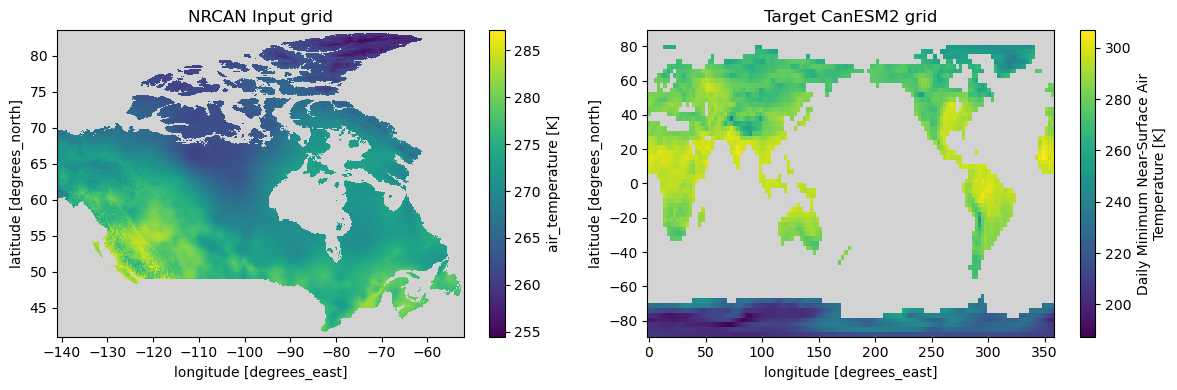

In [43]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

ds_in.tasmin.plot(ax=axs[0], cmap=cmap)
axs[0].set_title("NRCAN Input grid")

ds_tgt.tasmin.plot(ax=axs[1], cmap=cmap)
axs[1].set_title("Target CanESM2 grid")
fig.tight_layout()

### Default regridding - No mask handling

We first naïvely try the regridding exactly as before. Here we use the "conservative_normed" method, the reason is explained at the end of the example.

In [44]:
reg_nomask = xe.Regridder(ds_in, ds_tgt, "conservative_normed")
print(reg_nomask)
tasmin_nomask = reg_nomask(ds_in.tasmin)

xESMF Regridder 
Regridding algorithm:       conservative_normed 
Weight filename:            conservative_normed_510x1068_64x128.nc 
Reuse pre-computed weights? False 
Input grid shape:           (510, 1068) 
Output grid shape:          (64, 128) 
Periodic in longitude?      False


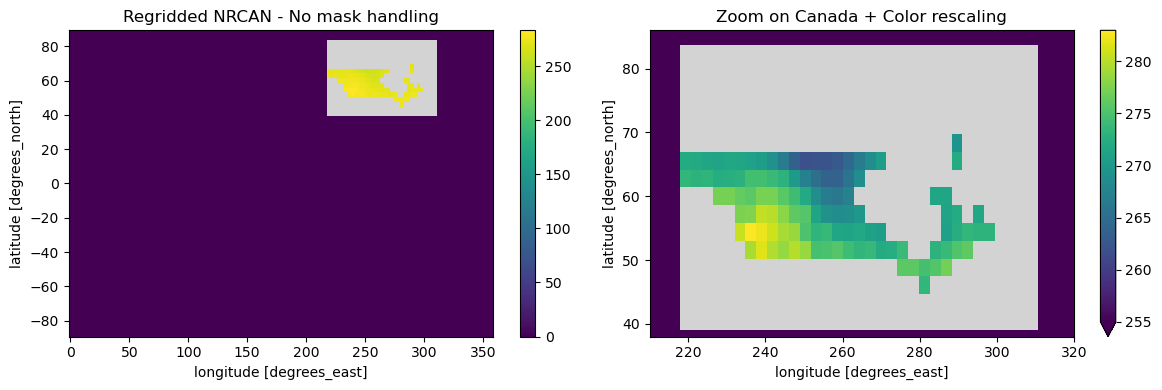

In [45]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

tasmin_nomask.plot(ax=axs[0], cmap=cmap)
axs[0].set_title("Regridded NRCAN - No mask handling")

tasmin_nomask.plot(ax=axs[1], cmap=cmap, vmin=255)
axs[1].set_xlim(210, 320)
axs[1].set_ylim(38, 86)
axs[1].set_title("Zoom on Canada + Color rescaling")
fig.tight_layout()

This ugly result is the default behaviour of xESMF when no mask information is passed :

1. A single missing value in the input suffices so that the target (coarser) grid cell is marked as missing. This erased all the Canadian Arctic Archipelago and most points near the sea in general.
2. Grid points outside the input grid are filled with 0s instead of NaNs. 

To resolve this, we pass as binary mask to xESMF. xESMF will then exclude the masked values from the computation, and this way the small islands in the Canadian Arctic Archipelago won't be hidden by missing values. It will also activate a mode where values outside the input grid are marked as missing (NaN), which is usually more useful.

Note that ESMF masks defined as `True` where data is valid, and `False` where it is missing. The variable must be named `mask` to get picked up by xESMF.

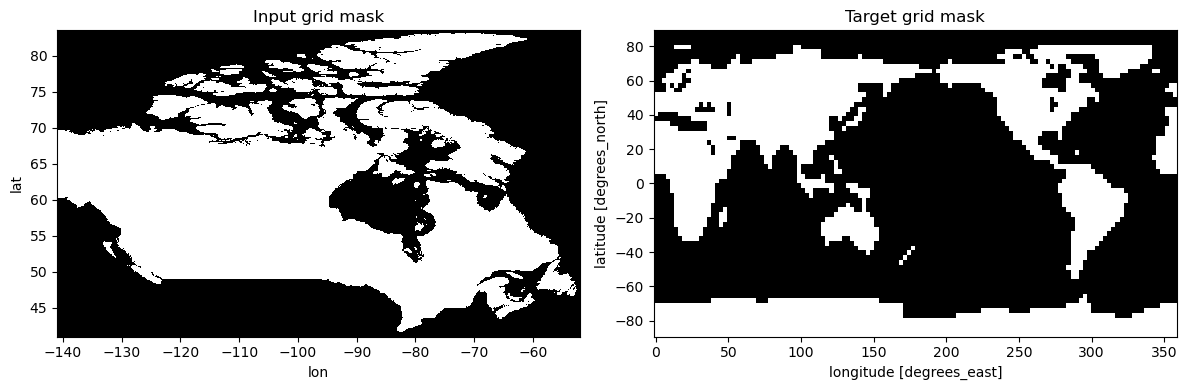

In [46]:
# Define the masks and assign them as variables for both the input and output datasets.
in_mask = ds_in.tasmin.notnull()
ds_in_mask = ds_in.assign(mask=in_mask)

tgt_mask = ds_tgt.tasmin.isel(time=0).notnull()
ds_tgt_mask = ds_tgt.assign(mask=tgt_mask)

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
in_mask.plot(ax=axs[0], cmap=plt.cm.binary_r, add_colorbar=False)
tgt_mask.plot(ax=axs[1], cmap=plt.cm.binary_r, add_colorbar=False)
axs[0].set_title("Input grid mask")
axs[1].set_title("Target grid mask")
fig.tight_layout()

In [47]:
reg_mask = xe.Regridder(ds_in_mask, ds_tgt_mask, "conservative_normed")
reg_mask  # Show information about the regridding

xESMF Regridder 
Regridding algorithm:       conservative_normed 
Weight filename:            conservative_normed_510x1068_64x128.nc 
Reuse pre-computed weights? False 
Input grid shape:           (510, 1068) 
Output grid shape:          (64, 128) 
Periodic in longitude?      False

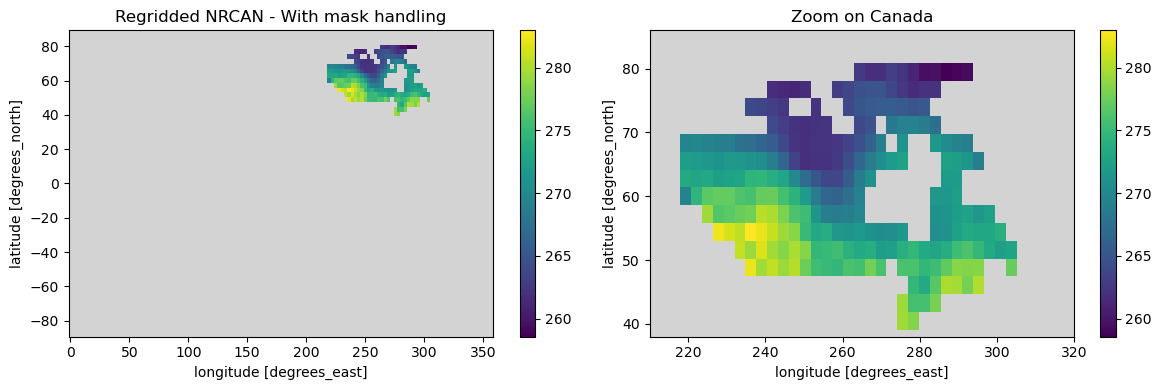

In [48]:
tasmin_mask = reg_mask(ds_in_mask.tasmin)
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

tasmin_mask.plot(ax=axs[0], cmap=cmap)
axs[0].set_title("Regridded NRCAN - With mask handling")

tasmin_mask.plot(ax=axs[1], cmap=cmap)
axs[1].set_xlim(210, 320)
axs[1].set_ylim(38, 86)
axs[1].set_title("Zoom on Canada")
fig.tight_layout()

Much better! As expected, grid cells near the sea are kept and points outside the input grid are marked as missing.

### Normalization for conservative regridding

The "conservative_normed" method includes information about the missing values in the final normalization of the data. On the other hand, the "conservative" method normalizes using the total area of the target cell, no matter how many input grid points were valid. The following figure shows how that can lead to large biases in the data near the boundaries. Indeed, in the example below, the temperatures reach values close to 0 Kelvins near the boundaries. 

Text(1.3, 0.3, 'Some values are close to 0 Kelvins.\nCanada can get cold, but not that cold!')

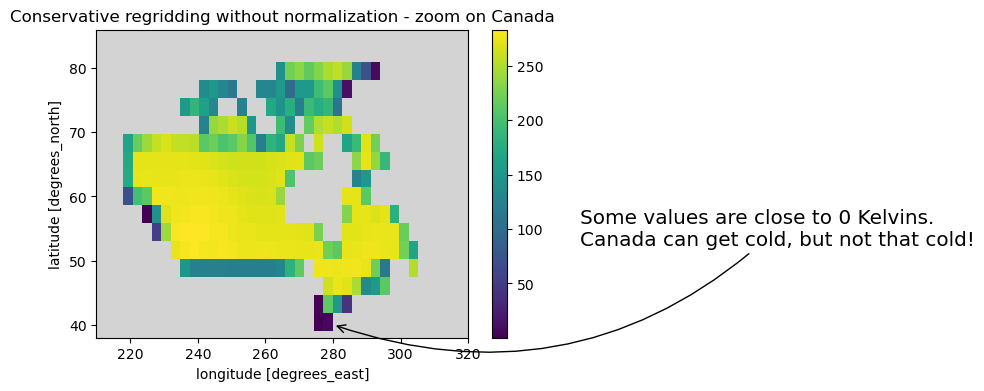

In [49]:
# NBVAL_IGNORE_OUTPUT

reg_mask_cons = xe.Regridder(ds_in_mask, ds_tgt_mask, "conservative")
tasmin_mask_cons = reg_mask_cons(ds_in_mask.tasmin)

fig, ax = plt.subplots(figsize=(6, 4))
tasmin_mask_cons.plot(cmap=cmap, ax=ax)
ax.set_xlim(210, 320)
ax.set_ylim(38, 86)
ax.set_title("Conservative regridding without normalization - zoom on Canada")
ax.annotate(
    "Some values are close to 0 Kelvins.\nCanada can get cold, but not that cold!",
    (280, 40),
    xytext=(1.3, 0.3),
    xycoords="data",
    textcoords="axes fraction",
    fontsize="x-large",
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=-0.3"),
)

## Fourth example : Averaging over polygons

Because the conservative regridding method preserves areal averages, we can use xESMF to compute *exact* averages over polygons. We call it "exact" because is takes into account partial overlaps between the gridcells and the shapes, including potential holes. While it is fast and powerful, this polygon averaging functionality is new in xESMF and still lacks some features, like missing values handling and performance issues with high-resolution polygons.

The following example grabs some polygon shapes from PAVICS' Geoserver and averages the NRCAN data over them.

### Define polygon shapes

This example fetches all MRC of Québec and then only selects 10 large ones.

In [50]:
wfs_url = "https://pavics.ouranos.ca/geoserver/wfs"  # TEST_USE_PROD_DATA
# # Connect to GeoServer WFS service.
wfs = WebFeatureService(wfs_url, version="2.0.0")
# Get the json as a binary stream
# Here we select Quebec's MRCs polygons
# We select only a few properties
data = wfs.getfeature(
    typename="public:quebec_mrc_boundaries",
    # bbox=(-93.1, 41.1, -75.0, 49.6),
    outputFormat="json",
    propertyname=["the_geom", "MRS_NM_MRC"],
)

# Load into a GeoDataFrame by reading the json on-the-fly
shapes_all = gpd.GeoDataFrame.from_features(json.load(data))
# Just for simplicity, let's take 10 large MRCs
shapes_all["AREA"] = shapes_all.area
shapes = shapes_all.sort_values("AREA").iloc[-20:-10].set_index("MRS_NM_MRC")

### Validate and simplify shapes

High resolution polygons might slow down the creation of the xESMf averager object. Here we ensure polygons are simplified to a resolution 50x times finer than the input data. This should have a minimal impact on the output while still improving performance.

As it is the case here, downloaded polygons sometime have topological problems which can be tested with `shapes.is_valid`. Simplifying polygons sometimes help overcome these issues:  here, we simplify with a tolerance of 1/100th of the grid size. Another workaround for self-intersections is to call `shapes.buffer(0)`.

In [51]:
# NBVAL_IGNORE_OUTPUT
shapes.is_valid.all()

np.False_

In [52]:
# This is only to show the decrease in size


def count_points(elem):
    def _count(poly):
        return len(poly.exterior.coords) + sum(
            len(hole.coords) for hole in poly.interiors
        )

    if isinstance(elem, shapely.geometry.MultiPolygon):
        return sum(_count(poly) for poly in elem.geoms)
    return _count(elem)


# Count the total number of nodes in the shapes:
print(
    "Total number of nodes in the raw shapes : ",
    shapes.geometry.apply(count_points).sum(),
)

min_grid_size = float(
    min(abs(ds_in.lat.diff("lat")).min(), abs(ds_in.lon.diff("lon")).min())
)
print(
    f"Minimal grid size [°] of input ds: {min_grid_size:0.3f}, we will simplify to a tolerance of {min_grid_size / 100:0.5f}"
)

# Simplify geometries
shapes_simp = shapes.copy()
shapes_simp["geometry"] = shapes.simplify(min_grid_size / 100).buffer(0)

print(
    "Total number of nodes in the simplified shapes : ",
    shapes_simp.geometry.apply(count_points).sum(),
)
if shapes_simp.buffer(0).is_valid.all():
    print("All shapes are valid")

Total number of nodes in the raw shapes :  166813
Minimal grid size [°] of input ds: 0.083, we will simplify to a tolerance of 0.00083
Total number of nodes in the simplified shapes :  7231
All shapes are valid


### Averaging over each polygon

Performing the spatial average is as simple as regridding. We first construct a `SpatialAverager` object from the input grid and polygons, then call it with the data to average. Note that xESMf expects a list of shapes, so we pass the `shapes.geometry` series (and not the `GeoDataFrame` itself).

The returned DataArray was averaged along its spatial (`lat`/`lon`) dimensions and the average over the different shapes are along the new `geom` dimension, which is in the same order as the initial `GeoDataframe`.

The current missing value handling in xESMF's SpatialAverager is very strict, and we can see here how the three (3) MRCs that overlap with ocean cells of the data (where `tasmin` is `NaN`) are flagged as missing (`NaN`).

In [53]:
# NBVAL_IGNORE_OUTPUT
savg = xe.SpatialAverager(ds_in, shapes_simp.geometry)
tn_avg = savg(ds_in.tasmin)
tn_avg

/home/tjs/miniforge3/envs/pavics-sdi/lib/python3.10/site-packages/xesmf/frontend.py:1229: UserWarning: `polys` contains large (> 1°) segments. This could lead to errors over large regions. For a more accurate average, segmentize (densify) your shapes with  `shapely.segmentize(polys, 1)`
  self._check_polys_length(polys)


<xarray.DataArray (geom: 10)> Size: 40B
array([      nan,       nan, 274.64337, 275.4841 ,       nan, 276.23572,
       274.05746, 276.86087, 275.4918 , 276.8586 ], dtype=float32)
Coordinates:
    lon      (geom) float64 80B -66.01 -63.91 -77.09 ... -73.26 -76.76 -73.98
    lat      (geom) float64 80B 49.21 48.29 46.43 46.91 ... 48.81 48.15 48.04
Dimensions without coordinates: geom
Attributes:
    regrid_method:  conservative

### Merging polygon features' properties into the result

In the previous results, the polygons are indexed along the `geom` dimension, but we'd like to have the region names and properties. 

In [54]:
# NBVAL_IGNORE_OUTPUT

# Set coordinates of "geom" to the shapes index
tn_avg["geom"] = shapes_simp.index.values

# Get a Dataset of properties from the dataframe
# Drop the geometries (we don't want them), convert to xarray and rename the index so it matches the one in tn_avg
props = shapes_simp.drop(columns=["geometry"]).to_xarray().rename(MRS_NM_MRC="geom")

# Assign all properties as "auxiliary" coordinates
tn_avg = tn_avg.assign_coords(**props.data_vars)
tn_avg

<xarray.DataArray (geom: 10)> Size: 40B
array([      nan,       nan, 274.64337, 275.4841 ,       nan, 276.23572,
       274.05746, 276.86087, 275.4918 , 276.8586 ], dtype=float32)
Coordinates:
    lon      (geom) float64 80B -66.01 -63.91 -77.09 ... -73.26 -76.76 -73.98
    lat      (geom) float64 80B 49.21 48.29 46.43 46.91 ... 48.81 48.15 48.04
  * geom     (geom) object 80B 'La Haute-Gaspésie' ... 'La Tuque'
    AREA     (geom) float64 80B 1.415 1.543 1.654 1.673 ... 2.364 3.307 3.573
Attributes:
    regrid_method:  conservative

Or, on the contrary, we could want to merge the averaged data to the dataframe instead.

In [55]:
# NBVAL_IGNORE_OUTPUT
shapes_data = shapes_simp.copy()
shapes_data["tasmin"] = tn_avg.to_series()
shapes_data

,geometry,AREA,tasmin
MRS_NM_MRC,,,
La Haute-Gaspésie,"POLYGON ((-65.1956 49.2296, -65.1872 49.0994, ...",1.414604,NaN
Le Rocher-Percé,"POLYGON ((-62.9991 48.7018, -62.9991 47.1572, ...",1.542547,NaN
Pontiac,"POLYGON ((-77.9313 47.2692, -77.6473 47.2693, ...",1.653789,274.643372
La Vallée-de-la-Gatineau,"POLYGON ((-76.2703 47.6899, -76.27 47.692, -76...",1.672640,275.484100
La Haute-Côte-Nord,"POLYGON ((-69.5082 49.9983, -69.5105 49.9979, ...",1.800530,NaN
Antoine-Labelle,"POLYGON ((-75.5386 47.7633, -74.8894 47.7626, ...",1.923892,276.235718
Témiscamingue,"MULTIPOLYGON (((-77.5792 47.4424, -77.5863 47....",2.282582,274.057465
Le Domaine-du-Roy,"POLYGON ((-73.6826 49.9973, -73.6844 49.997, -...",2.363714,276.860870
La Vallée-de-l'Or,"MULTIPOLYGON (((-77.5792 47.4424, -77.5729 47....",3.306656,275.491791


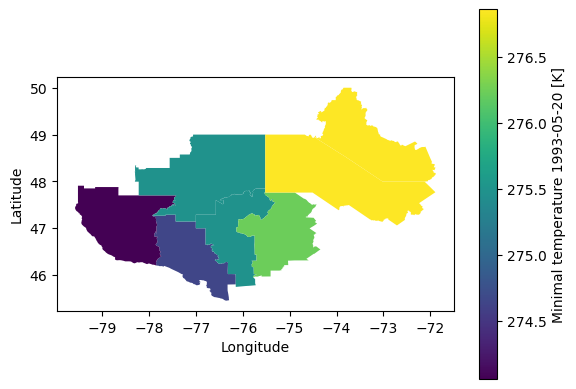

In [56]:
# NBVAL_IGNORE_OUTPUT

# Now we can plot easily the results as a choropleth map!
ax = shapes_data.plot(
    "tasmin", legend=True, legend_kwds={"label": "Minimal temperature 1993-05-20 [K]"}
)
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude");